In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load the dataset
dataset = torch.load("HAM10000Skin_Cancer_Balanced.pt")

# Extract images and metadata
images = dataset["images"]
metadata = dataset["metadata"]

# Extract labels (assume dx is stored in the first column of metadata)
labels = metadata[:, 0].long()

# Create a DataFrame for clinical data (excluding labels)
clinical_data = pd.DataFrame(metadata[:, 1:].numpy(), columns=[
    f"clinical_{i}" for i in range(1, metadata.size(1))
])

classnames = classname = [
    "Benign lesions of the keratosis",
    "Basal cell carcinoma",
    "Dermatofibroma",
    "Melanoma",
    "Melanocylabels",
    "tic nevi",
    "Vascular lesions",
    "Actinic keratoses"
]
label_dict = {abbr: name for abbr, name in zip(["bkl", "bcc", "df", "mel", "nv", "vasc", "akiec"], classnames)}

# Split data into train and test
train_ratio = 0.85
train_size = int(train_ratio * len(images))
test_size = len(images) - train_size

indices = torch.randperm(len(images)).tolist()  # Shuffle indices
train_indices, test_indices = indices[:train_size], indices[train_size:]

# Split data
X_train_images = images[train_indices]
X_test_images = images[test_indices]
X_train_clin = clinical_data.iloc[train_indices]
X_test_clin = clinical_data.iloc[test_indices]
y_train = labels[train_indices]
y_test = labels[test_indices]

# Create a custom dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, images, clinical_data, labels):
        self.images = images
        self.clinical_data = clinical_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "image": self.images[idx],
            "clinical_data": torch.tensor(self.clinical_data.iloc[idx].values, dtype=torch.float32),
            "label": self.labels[idx]
        }

# Create datasets
train_dataset = SkinCancerDataset(X_train_images, X_train_clin, y_train)
test_dataset = SkinCancerDataset(X_test_images, X_test_clin, y_test)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print summary
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print(f"Classnames: {classnames}")
print(f"Label dictionary: {label_dict}")


C:\Users\dasad\AppData\Local\Temp\ipykernel_21192\3088060718.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("HAM10000Skin_Cancer_Balanced.pt")


Train size: 17850, Test size: 3150
Classnames: ['Benign lesions of the keratosis', 'Basal cell carcinoma', 'Dermatofibroma', 'Melanoma', 'Melanocylabels', 'tic nevi', 'Vascular lesions', 'Actinic keratoses']
Label dictionary: {'bkl': 'Benign lesions of the keratosis', 'bcc': 'Basal cell carcinoma', 'df': 'Dermatofibroma', 'mel': 'Melanoma', 'nv': 'Melanocylabels', 'vasc': 'tic nevi', 'akiec': 'Vascular lesions'}


In [2]:
import torch
import torch.nn as nn

class WeightedResnet(nn.Module):
    def __init__(self, in_channels, num_classes, initial_res_weights=0.001):
        super(WeightedResnet, self).__init__()

        # Initialize res_weights as a learnable parameter
        self.res_weights = nn.Parameter(torch.tensor(initial_res_weights, dtype=torch.float32))

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.res3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.res4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout(0.1),
            nn.BatchNorm2d(512)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + self.res_weights * x

        x = self.conv3(x)
        x = self.res2(x) + self.res_weights * x

        x = self.conv4(x)
        x = self.res3(x) + self.res_weights * x

        x = self.conv5(x)
        x = self.res4(x) + self.res_weights * x

        x = self.classifier(x)
        x = self.softmax(x)

        return x


In [3]:
model = WeightedResnet
print(model)

<class '__main__.WeightedResnet'>


In [4]:
class ClinicalNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClinicalNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [5]:
class SelfAttentionFusion(nn.Module):
    def __init__(self, image_model, clinical_model, num_classes, image_feature_dim=512, clinical_feature_dim=256):
        super(SelfAttentionFusion, self).__init__()
        self.image_model = image_model
        self.clinical_model = clinical_model

        # Project clinical features to match image features
        self.clinical_projection = nn.Linear(clinical_feature_dim, image_feature_dim)

        # Self Attention Layer for image features
        self.self_attention = nn.MultiheadAttention(embed_dim=image_feature_dim, num_heads=8)

        # Final classification layer
        self.fc = nn.Linear(image_feature_dim, num_classes)

    def forward(self, image, clinical):
        # Extract features from both models
        image_features = self.image_model(image)  # Shape: [batch_size, image_feature_dim]
        clinical_features = self.clinical_model(clinical)  # Shape: [batch_size, clinical_feature_dim]

        # Project clinical features to match image features
        clinical_features = self.clinical_projection(clinical_features)  # Shape: [batch_size, image_feature_dim]

        # Reshape for MultiheadAttention (requires [seq_len, batch_size, embed_dim])
        image_features = image_features.unsqueeze(0)  # Shape: [1, batch_size, image_feature_dim]

        # Self Attention: Attend to image features
        attended_image_features, _ = self.self_attention(
            query=image_features, key=image_features, value=image_features
        )  # Shape: [1, batch_size, image_feature_dim]

        # Reshape back to [batch_size, image_feature_dim]
        attended_image_features = attended_image_features.squeeze(0)

        # Combine attended image features with clinical features (simple addition)
        combined_features = attended_image_features + clinical_features

        # Final classification
        output = self.fc(combined_features)  # Shape: [batch_size, num_classes]
        return output

Epoch 1/1: 100%|██████████████████████████████████████████████████| 279/279 [02:58<00:00,  1.57it/s]


Epoch 1/1
Train Loss: 1.6473, Train Accuracy: 39.29%
Test Loss: 1.2337, Test Accuracy: 50.41%, Test Recall: 50.07%


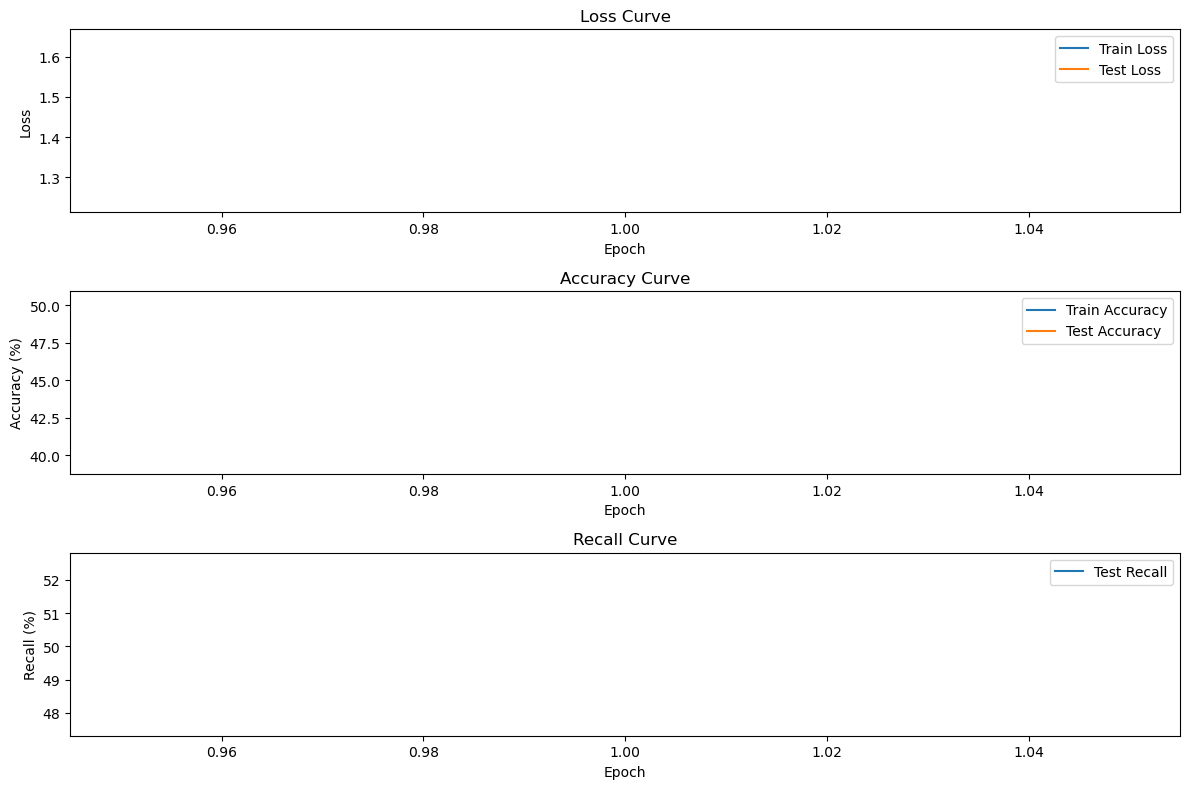

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Set the device for training (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
num_classes = len(set(labels))
resnet_model = WeightedResnet(in_channels=3, num_classes=num_classes).to(device)
clinical_nn = ClinicalNN(input_dim=X_train_clin.shape[1], num_classes=num_classes).to(device)
combined_model = SelfAttentionFusion(image_model=resnet_model, clinical_model=clinical_nn, num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Number of epochs
num_epochs = 1

# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
test_recalls = []

# Training loop with tqdm and GPU support
for epoch in range(1, num_epochs + 1):
    combined_model.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Train the model
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", ncols=100):
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Compute average training loss and accuracy for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100

    # Evaluate on test set
    combined_model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_labels, all_predictions = [], []
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch in test_loader:
            images = batch["image"].to(device)
            clinical_data = batch["clinical_data"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = combined_model(images, clinical_data)
            
            # Compute loss
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

            # Collect labels and predictions for recall computation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute average test loss and accuracy
    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test * 100
    test_recall = recall_score(all_labels, all_predictions, average="macro") * 100

    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    test_recalls.append(test_recall)

    # Print metrics
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Recall: {test_recall:.2f}%")

    # Save checkpoint periodically
    if epoch % 10 == 0:
        torch.save(combined_model.state_dict(), f"checkpoint_epoch_{epoch}.pt")

    if test_accuracy > 95:
        break;

# Plot metrics
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 8))

# Loss curve
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curve
plt.subplot(3, 1, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

# Recall curve
plt.subplot(3, 1, 3)
plt.plot(epochs, test_recalls, label="Test Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall (%)")
plt.title("Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
torch.save(combined_model, "FinalWeights/SelfAttentionFusion.pt")

In [8]:
class_names = classnames 

Original Classnames:
0: Benign lesions of the keratosis
1: Basal cell carcinoma
2: Dermatofibroma
3: Melanoma
4: Melanocylabels
5: tic nevi
6: Vascular lesions
7: Actinic keratoses


C:\Users\dasad\AppData\Local\Temp\ipykernel_29580\2957506192.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("FinalWeights/SelfAttentionFusion

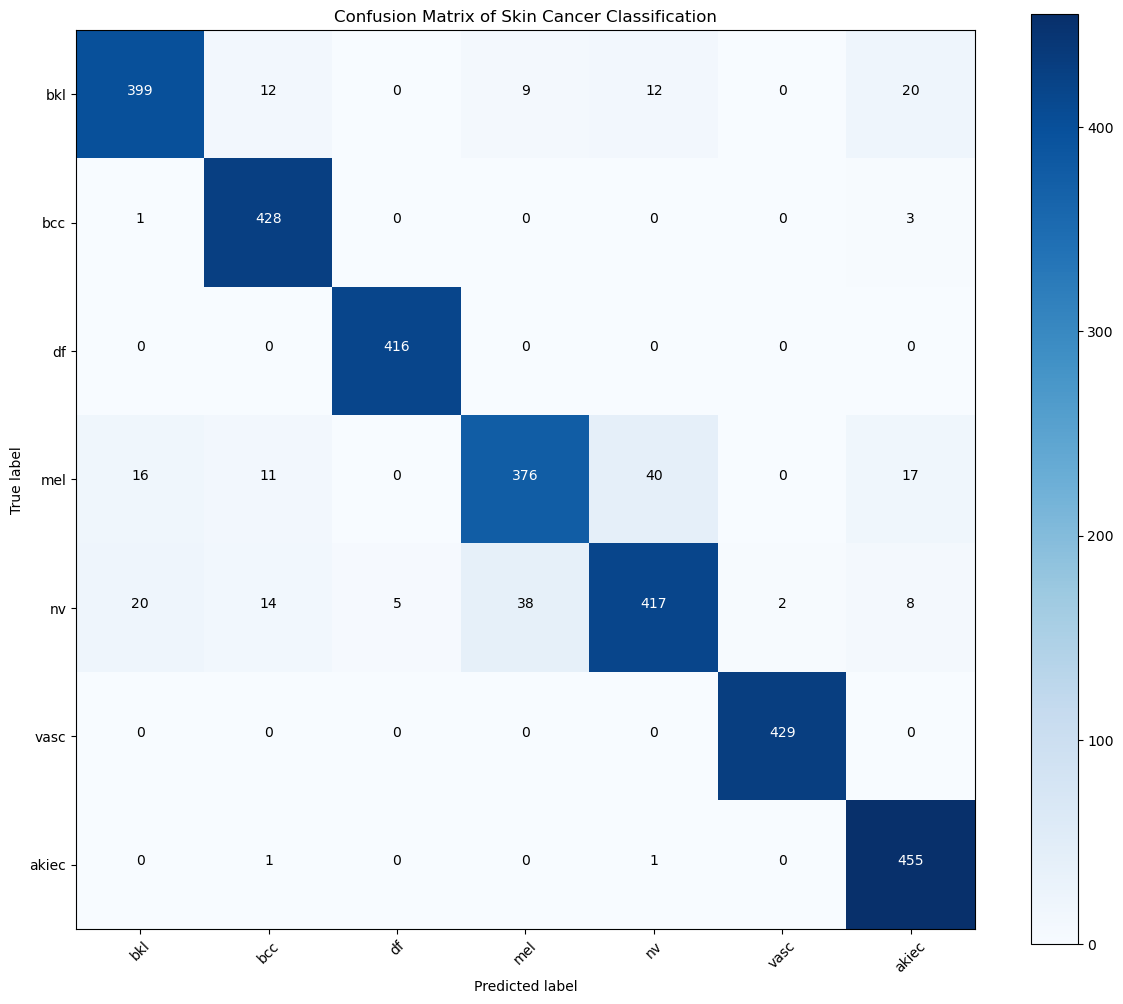

Test Data Classification Report:
               precision    recall  f1-score   support

         bkl     0.9151    0.8827    0.8986       452
         bcc     0.9185    0.9907    0.9532       432
          df     0.9881    1.0000    0.9940       416
         mel     0.8889    0.8174    0.8516       460
          nv     0.8872    0.8274    0.8563       504
        vasc     0.9954    1.0000    0.9977       429
       akiec     0.9046    0.9956    0.9479       457

    accuracy                         0.9270      3150
   macro avg     0.9283    0.9306    0.9285      3150
weighted avg     0.9263    0.9270    0.9257      3150


Training Data Classification Report:
               precision    recall  f1-score   support

         bkl     0.9721    0.9698    0.9709      2548
         bcc     0.9651    0.9907    0.9777      2568
          df     0.9965    1.0000    0.9983      2584
         mel     0.9693    0.9201    0.9441      2540
          nv     0.9548    0.9403    0.9475      2496
     

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Print out the original classnames to verify
print("Original Classnames:")
for i, name in enumerate(classnames):
    print(f"{i}: {name}")

# Corrected label dictionary to match exact class names
label_dict = {
    "bkl": "Benign lesions of the keratosis",
    "bcc": "Basal cell carcinoma", 
    "df": "Dermatofibroma", 
    "mel": "Melanoma", 
    "nv": "Melanocytic nevi", 
    "vasc": "Vascular lesions", 
    "akiec": "Actinic keratoses"
}

# Reverse the dictionary for abbreviation lookup
abbrev_dict = {v: k for k, v in label_dict.items()}

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = torch.load("FinalWeights/SelfAttentionFusion.pt").to(device)
loaded_model.eval()

# Prepare to collect predictions and true labels
all_preds = []
all_labels = []

# Collect predictions
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)
        
        outputs = loaded_model(images, clinical_data)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Prepare class names and abbreviations
# Directly use the original classnames list
class_names = classnames
class_abbrevs = list(label_dict.keys())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Skin Cancer Classification')
plt.colorbar()

# Add text annotations
tick_marks = np.arange(len(class_abbrevs))
plt.xticks(tick_marks, class_abbrevs, rotation=45)
plt.yticks(tick_marks, class_abbrevs)

# Add text values in each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Compute classification report
report = classification_report(
    all_labels, 
    all_preds, 
    target_names=class_abbrevs,
    digits=4
)
print("Test Data Classification Report:\n", report)

# Same for training data
train_preds = []
train_labels = []

with torch.no_grad():
    for batch in train_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)
        
        outputs = loaded_model(images, clinical_data)
        _, preds = torch.max(outputs, 1)
        
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
train_preds = np.array(train_preds)
train_labels = np.array(train_labels)

# Compute training classification report
train_report = classification_report(
    train_labels, 
    train_preds, 
    target_names=class_abbrevs,
    digits=4
)
print("\nTraining Data Classification Report:\n", train_report)

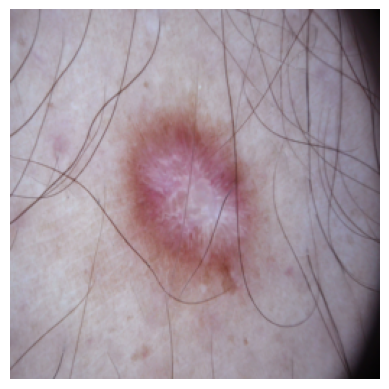

Clinical Data:
    Age    Dx Type      Sex    Localization
0  45.0  Follow-up  Unknown  Abdomen, Scalp

Prediction Probabilities:
Benign lesions of the keratosis: 0.0000
Basal cell carcinoma: 0.0000
Dermatofibroma: 1.0000
Melanoma: 0.0000
Melanocytic nevi: 0.0000
Vascular lesions: 0.0000
Actinic keratoses: 0.0000

Actual Class: Dermatofibroma
Predicted Class: Dermatofibroma


In [10]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select a random index from the test set
random_idx = np.random.randint(0, len(test_dataset))

# Get the sample
sample = test_dataset[random_idx]

# Get the image and clinical data
image = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
clinical_data = sample['clinical_data'].unsqueeze(0).to(device)  # Add batch dimension
actual_label = sample['label']

# Get the clinical data as a DataFrame (for better display)
clinical_data_dict = sample['clinical_data'].cpu().numpy()

# Determine the dx_type based on the columns 'dx_type_confocal', 'dx_type_consensus', and 'dx_type_follow_up'
dx_type = ''
if clinical_data_dict[0] == 1:
    dx_type = 'Confocal'
elif clinical_data_dict[1] == 1:
    dx_type = 'Consensus'
elif clinical_data_dict[2] == 1:
    dx_type = 'Follow-up'

# Determine the sex based on the 'sex_female' and 'sex_male' columns
sex = ''
if clinical_data_dict[4] == 1:
    sex = 'Female'
elif clinical_data_dict[5] == 1:
    sex = 'Male'
else:
    sex = 'Unknown'

# Determine the localization (only the body part where lesion is located is shown)
localization = []
local_columns = [
    'local_abdomen', 'local_acral', 'local_back', 'local_chest', 'local_ear', 'local_face', 'local_foot',
    'local_genital', 'local_hand', 'local_lower extremity', 'local_neck', 'local_scalp', 'local_trunk',
    'local_unknown', 'local_upper extremity'
]
for i, loc in enumerate(local_columns):
    if clinical_data_dict[i + 6] == 1:  # Skip the first 6 columns for dx_type and sex
        localization.append(loc.replace('local_', '').replace('_', ' ').capitalize())

# Create the DataFrame
clinical_df = pd.DataFrame([{
    'Age': clinical_data_dict[0],
    'Dx Type': dx_type,
    'Sex': sex,
    'Localization': ', '.join(localization) if localization else 'Unknown'
}], columns=['Age', 'Dx Type', 'Sex', 'Localization'])

# Get the prediction from the combined model
combined_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = combined_model(image, clinical_data)

# Get the probabilities of each class
probs = torch.softmax(output, dim=1).cpu().numpy().flatten()

# Define the class names based on your dataset
class_names = [
    'Benign lesions of the keratosis', 
    'Basal cell carcinoma', 
    'Dermatofibroma', 
    'Melanoma', 
    'Melanocytic nevi', 
    'Vascular lesions', 
    'Actinic keratoses'
]

# Get the predicted class
predicted_class = np.argmax(probs)

# Plot the image
plt.imshow(sample['image'].permute(1, 2, 0))  # Change from [C, H, W] to [H, W, C]
plt.axis('off')  # Hide axes
plt.show()

# Display the clinical data
print("Clinical Data:")
print(clinical_df)

# Display the prediction probabilities for each class
print("\nPrediction Probabilities:")
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {probs[idx]:.4f}")

# Display the actual class and predicted class
print("\nActual Class:", class_names[actual_label])
print("Predicted Class:", class_names[predicted_class])


In [11]:
clinical_df

Age    Dx Type      Sex    Localization
0  45.0  Follow-up  Unknown  Abdomen, Scalp

In [16]:
class_names = classnames
class_names

['Benign lesions of the keratosis',
 'Basal cell carcinoma',
 'Dermatofibroma',
 'Melanoma',
 'Melanocylabels',
 'tic nevi',
 'Vascular lesions',
 'Actinic keratoses']

In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch.nn.functional as F
import seaborn as sns
import pandas as pd

class ModelVisualizer:
    def __init__(self, model_path, device='cuda'):
        self.device = device
        self.model = torch.load(model_path).to(device)
        self.model.eval()
        
        # Define clinical feature names
        self.clinical_feature_names = [
            "Age",
            "Dx Type: Confocal",
            "Dx Type: Consensus",
            "Dx Type: Follow-Up",
            "Dx Type: Histopathology",
            "Sex: Female",
            "Sex: Male",
            "Sex: Unknown",
            "Localization: Abdomen",
            "Localization: Acral",
            "Localization: Back",
            "Localization: Chest",
            "Localization: Ear",
            "Localization: Face",
            "Localization: Foot",
            "Localization: Genital",
            "Localization: Hand",
            "Localization: Lower Extremity",
            "Localization: Neck",
            "Localization: Scalp",
            "Localization: Trunk",
            "Localization: Unknown",
            "Localization: Upper Extremity"
        ]
        
    def generate_gradcam(self, image, clinical_data, target_layer_name='conv5'):
        """
        Generate smooth Grad-CAM visualization for the image pathway
        """
        # Register hooks for the target layer
        activation = None
        gradients = None
        
        def save_activation(module, input, output):
            nonlocal activation
            activation = output
            
        def save_gradient(module, grad_input, grad_output):
            nonlocal gradients
            gradients = grad_output[0]
        
        # Find target layer
        target_layer = None
        for name, module in self.model.image_model.named_modules():
            if name == target_layer_name:
                target_layer = module
                break
                
        if target_layer is None:
            raise ValueError(f"Layer {target_layer_name} not found")
            
        # Register hooks
        handle1 = target_layer.register_forward_hook(save_activation)
        handle2 = target_layer.register_backward_hook(save_gradient)
        
        # Forward pass
        image_tensor = image.unsqueeze(0).to(self.device)
        clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
        
        output = self.model(image_tensor, clinical_tensor)
        pred = output.argmax(dim=1)
        
        # Backward pass
        self.model.zero_grad()
        output[0, pred].backward()
        
        # Remove hooks
        handle1.remove()
        handle2.remove()
        
        # Generate CAM
        weights = gradients.mean(dim=(2, 3))
        cam = (weights.unsqueeze(-1).unsqueeze(-1) * activation).sum(dim=1)
        cam = F.relu(cam)
        
        # Normalize and resize
        cam = F.interpolate(cam.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().detach().numpy()
        
        # Apply Gaussian blur for smoothness
        cam = cv2.GaussianBlur(cam, (15, 15), 10)
        
        # Normalize to [0, 1]
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam
    
    def generate_clinical_importance(self, image, clinical_data, baseline=None):
        """
        Generate instance-specific feature importance using integrated gradients
        
        Args:
            image (torch.Tensor): Input image tensor
            clinical_data (torch.Tensor): Input clinical data tensor
            baseline (torch.Tensor, optional): Baseline input for comparison
        
        Returns:
            numpy.ndarray: Feature importance scores
        """
        # Prepare inputs
        image_tensor = image.unsqueeze(0).to(self.device)
        clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
        
        # Create baseline if not provided (use zeros or mean of training data)
        if baseline is None:
            baseline_clinical = torch.zeros_like(clinical_tensor)
        else:
            baseline_clinical = baseline.unsqueeze(0).to(self.device)
        
        # Number of steps for integrated gradients
        steps = 50
        
        # Initialize accumulator for integrated gradients
        integrated_grads = torch.zeros_like(clinical_tensor)
        
        # Compute integrated gradients
        for alpha in torch.linspace(0, 1, steps):
            # Interpolate between baseline and actual input
            interpolated_clinical = baseline_clinical + alpha * (clinical_tensor - baseline_clinical)
            interpolated_clinical.requires_grad_(True)
            
            # Forward pass
            output = self.model(image_tensor, interpolated_clinical)
            pred_class = output.argmax(dim=1)
            
            # Backward pass
            self.model.zero_grad()
            output[0, pred_class].backward()
            
            # Accumulate gradients
            integrated_grads += interpolated_clinical.grad
        
        # Average the gradients
        integrated_grads /= steps
        
        # Compute feature importance (absolute values)
        importance = torch.abs(integrated_grads).squeeze().cpu().detach().numpy()
        
        # Normalize importance scores
        importance = (importance - importance.min()) / (importance.max() - importance.min() + 1e-8)
        
        return importance
    
    def visualize(self, image, clinical_data, class_names):
        """
        Updated visualization method to use instance-specific feature importance
        """
        # Generate attributions
        cam = self.generate_gradcam(image, clinical_data)
        clinical_importance = self.generate_clinical_importance(image, clinical_data)
        
        # Create visualization
        fig = plt.figure(figsize=(20, 12))
        
        # Plot original image
        ax1 = plt.subplot(2, 2, 1)
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.title('Original Image', fontsize=12, pad=10)
        plt.axis('off')
        
        # Plot Grad-CAM
        ax2 = plt.subplot(2, 2, 2)
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title('Grad-CAM Visualization', fontsize=12, pad=10)
        plt.axis('off')
        
        # Plot clinical feature importance
        ax3 = plt.subplot(2, 1, 2)
        importance_df = pd.DataFrame({
            'Feature': self.clinical_feature_names,
            'Importance': clinical_importance
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(data=importance_df, y='Feature', x='Importance', 
                   palette='viridis', ax=ax3)
        plt.title('Instance-Specific Clinical Feature Importance', fontsize=12, pad=10)
        
        # Adjust layout for better readability
        ax3.set_xlabel('Relative Importance', fontsize=10)
        ax3.set_ylabel('Clinical Features', fontsize=10)
        ax3.tick_params(axis='both', which='major', labelsize=8)
        
        plt.tight_layout()
        return fig
    
    def get_prediction(self, image, clinical_data):
        """
        Get model prediction and confidence
        """
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(self.device)
            clinical_tensor = torch.tensor(clinical_data, 
                                        dtype=torch.float32).unsqueeze(0).to(self.device)
            
            output = self.model(image_tensor, clinical_tensor)
            probabilities = F.softmax(output, dim=1)
            
            pred_class = torch.argmax(probabilities).item()
            confidence = probabilities[0][pred_class].item()
            
        return pred_class, confidence

def plot_sample_predictions(visualizer, test_loader, class_names, num_samples=5):
    """
    Plot sample predictions with visualizations
    """
    samples = []
    for batch in test_loader:
        if len(samples) >= num_samples:
            break
        samples.extend([(batch['image'][i], 
                        batch['clinical_data'][i], 
                        batch['label'][i]) 
                       for i in range(len(batch['label']))])
    
    samples = samples[:num_samples]
    
    for image, clinical_data, true_label in samples:
        pred_class, confidence = visualizer.get_prediction(image, clinical_data)
        
        fig = visualizer.visualize(image, clinical_data, class_names)
        
        plt.suptitle(f'True: {class_names[true_label]}\n' \
                    f'Predicted: {class_names[pred_class]} ' \
                    f'(Confidence: {confidence:.2f})', 
                    y=1.02, fontsize=14)
        plt.show()

C:\Users\dasad\AppData\Local\Temp\ipykernel_11484\1494062385.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(model_path).to(device)
C:\Users\das

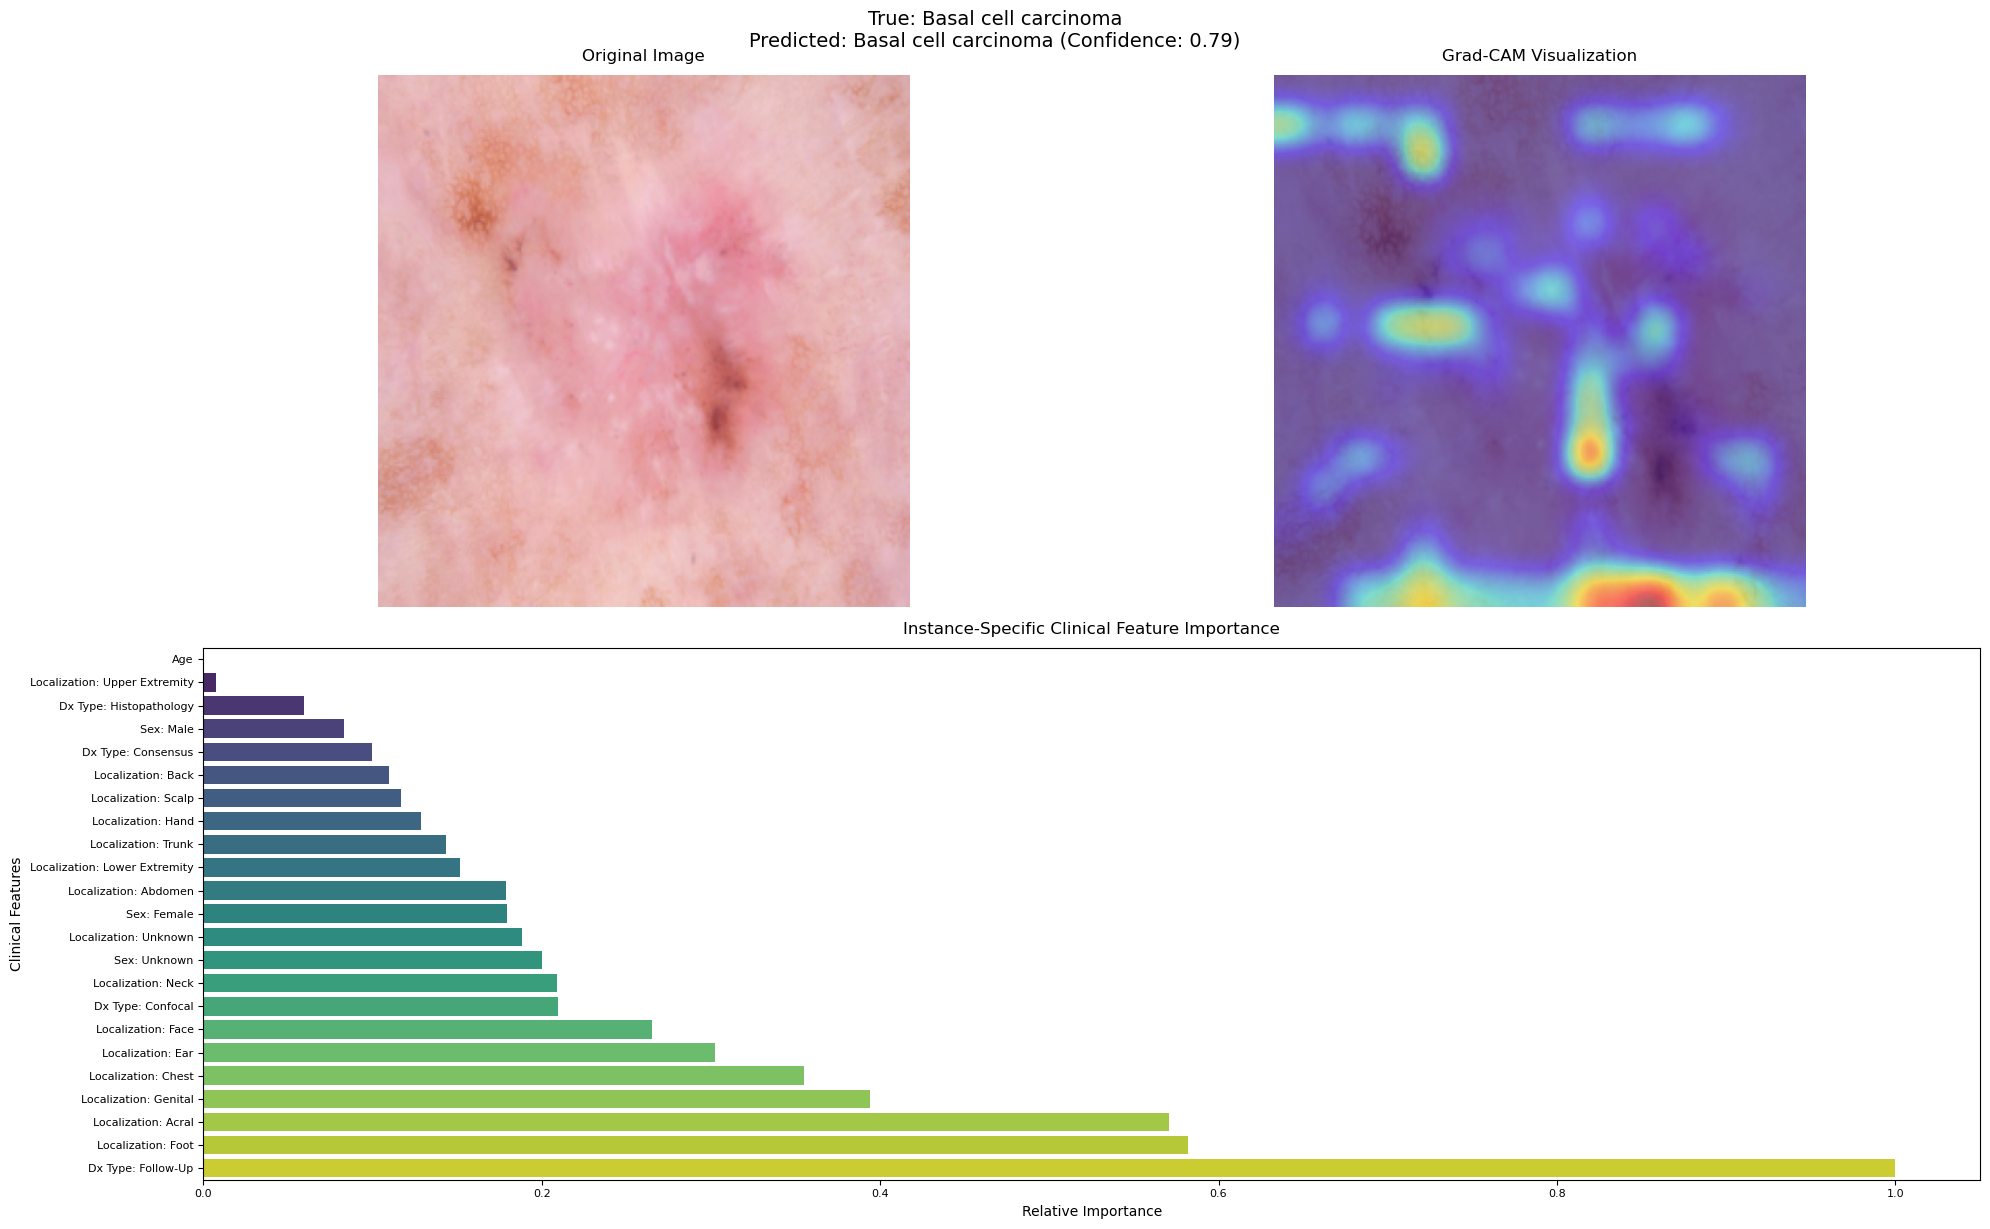

C:\Users\dasad\AppData\Local\Temp\ipykernel_11484\1494062385.py:212: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_11484\1494062385.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hoo

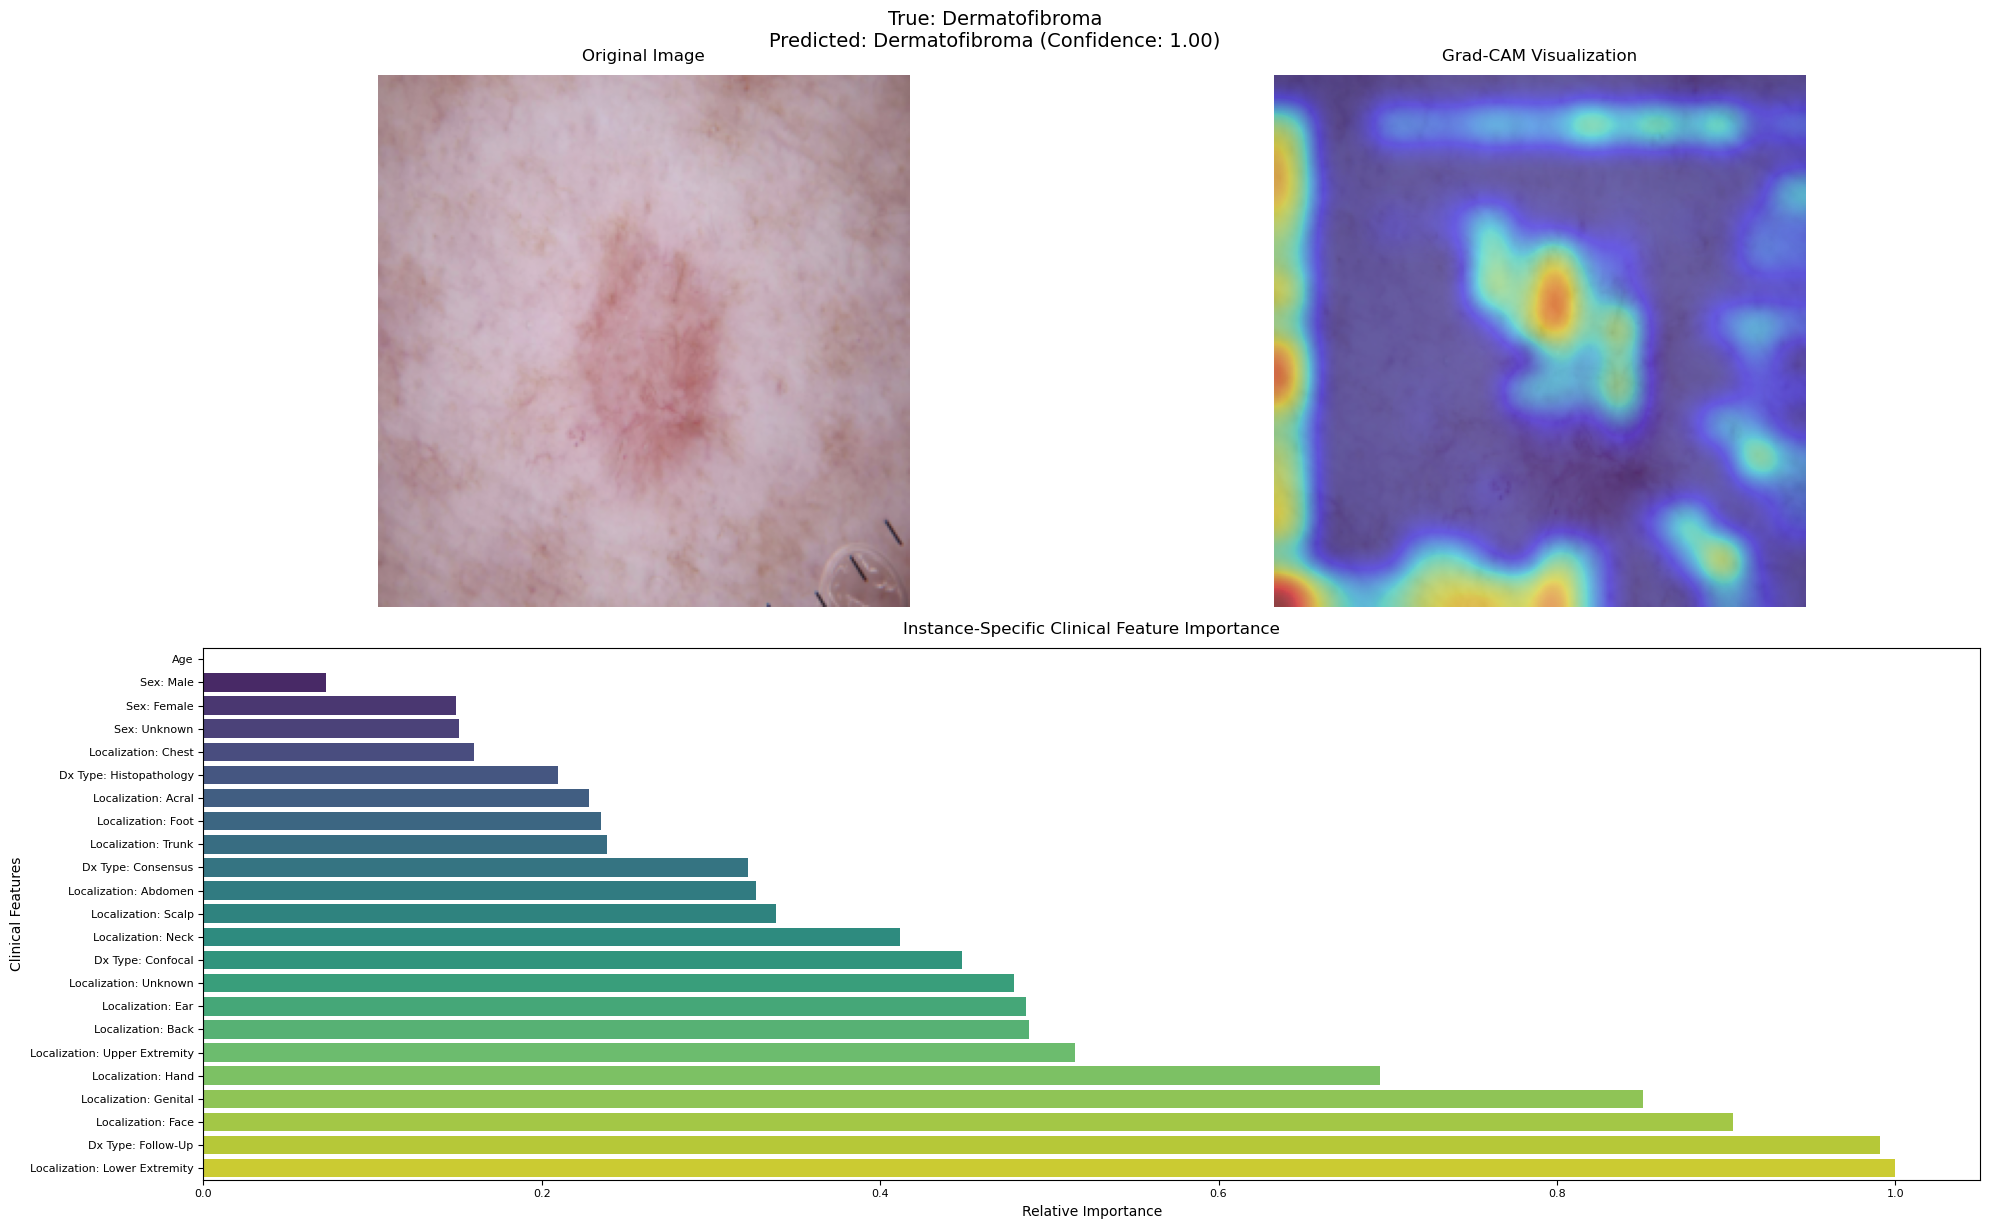

C:\Users\dasad\AppData\Local\Temp\ipykernel_11484\1494062385.py:212: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_11484\1494062385.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hoo

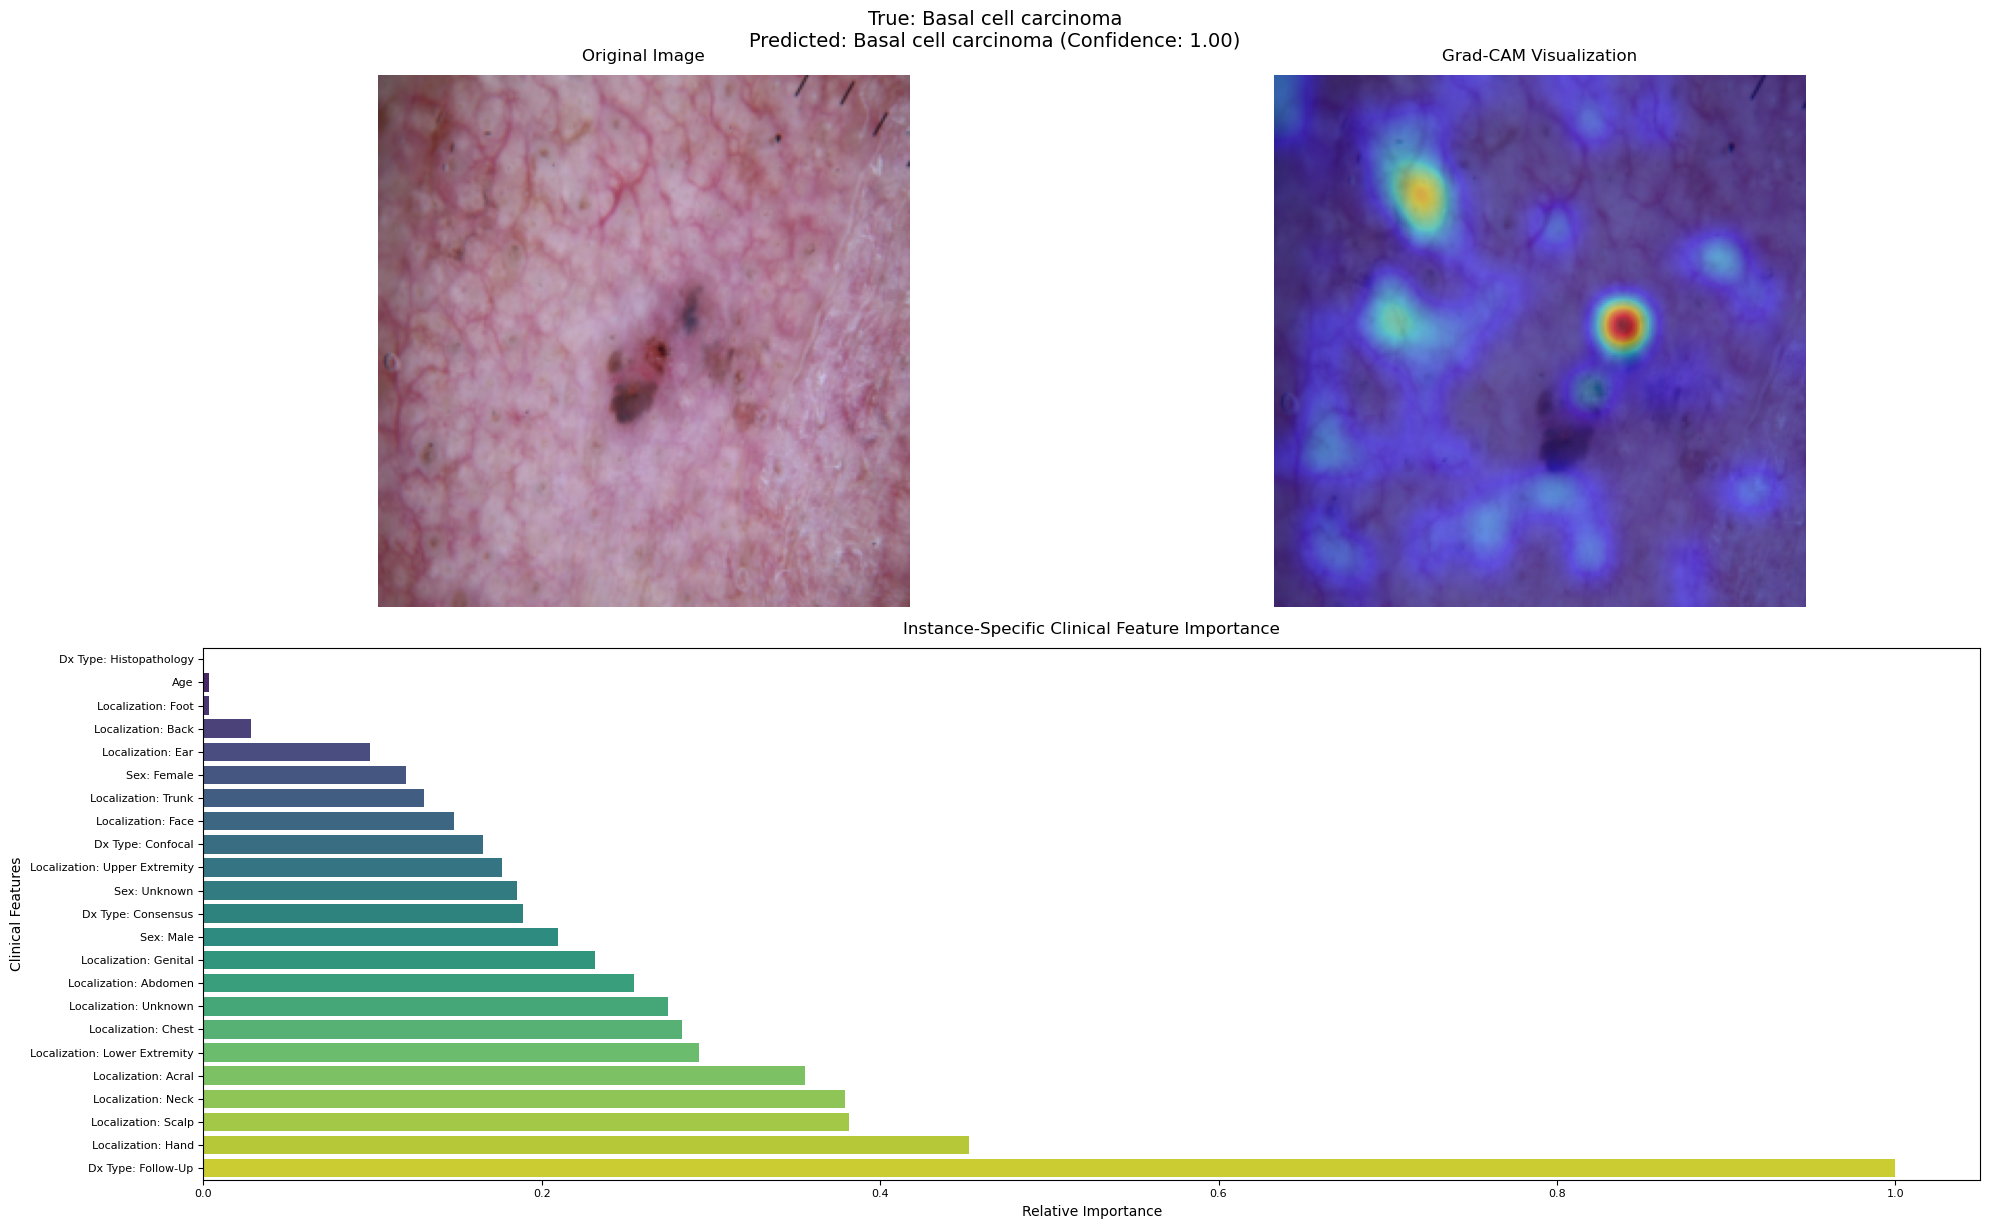

C:\Users\dasad\AppData\Local\Temp\ipykernel_11484\1494062385.py:212: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_11484\1494062385.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hoo

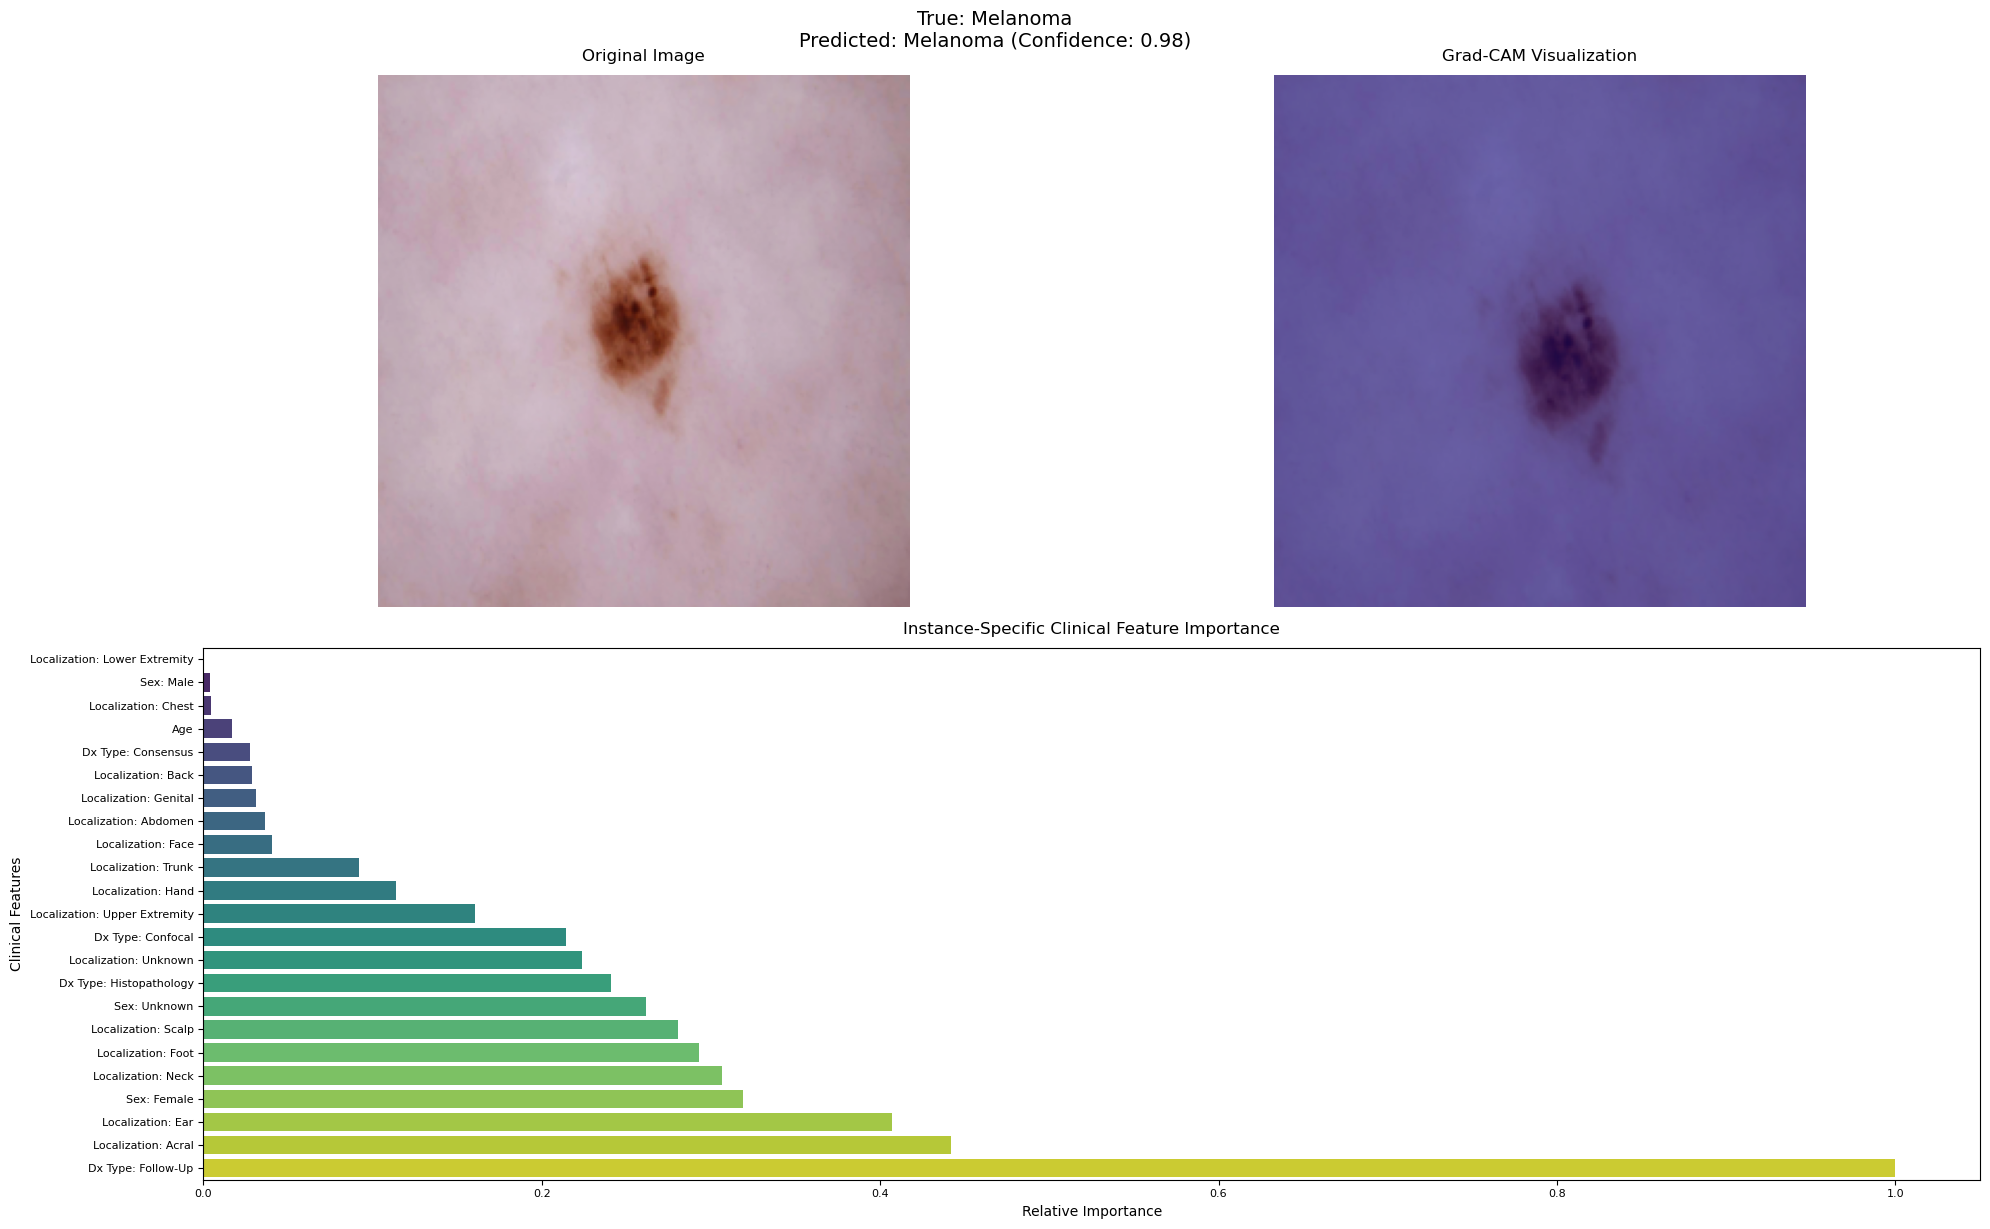

C:\Users\dasad\AppData\Local\Temp\ipykernel_11484\1494062385.py:212: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_11484\1494062385.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hoo

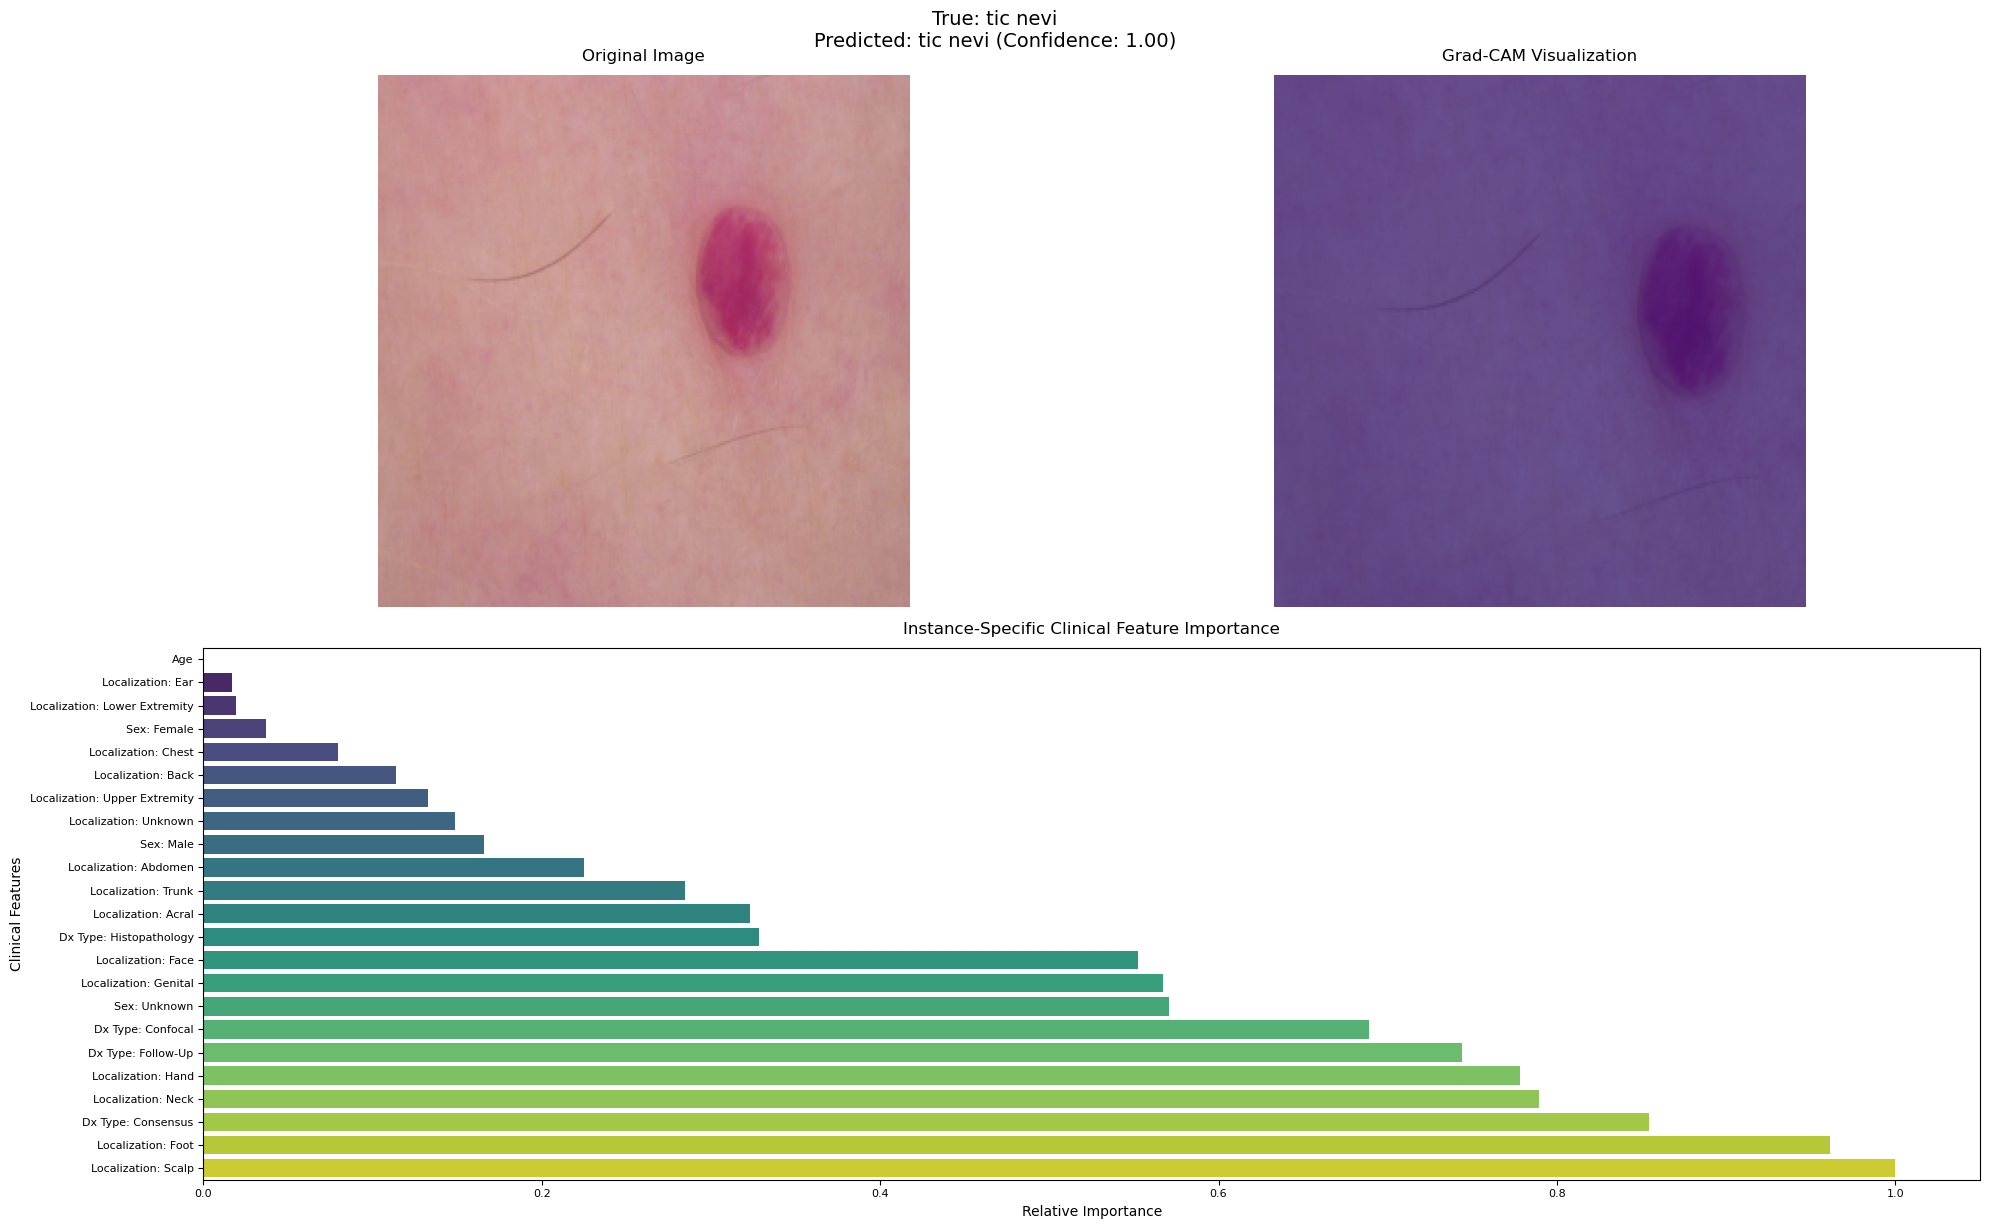

In [22]:
# Initialize the visualizer
visualizer = ModelVisualizer("FinalWeights/SelfAttentionFusion.pt")

# Generate visualizations for sample predictions
plot_sample_predictions(visualizer, test_loader, classnames)

In [ ]:
import torch
import numpy as np
import pandas as pd

class FeatureImportanceAnalyzer:
    def __init__(self, model_path, device='cuda'):
        self.device = device
        self.model = torch.load(model_path).to(device)
        self.model.eval()
        
        # Define clinical feature names
        self.clinical_feature_names = [
            "Age",
            "Dx Type: Confocal",
            "Dx Type: Consensus",
            "Dx Type: Follow-Up",
            "Dx Type: Histopathology",
            "Sex: Female",
            "Sex: Male",
            "Sex: Unknown",
            "Localization: Abdomen",
            "Localization: Acral",
            "Localization: Back",
            "Localization: Chest",
            "Localization: Ear",
            "Localization: Face",
            "Localization: Foot",
            "Localization: Genital",
            "Localization: Hand",
            "Localization: Lower Extremity",
            "Localization: Neck",
            "Localization: Scalp",
            "Localization: Trunk",
            "Localization: Unknown",
            "Localization: Upper Extremity"
        ]
    
    def calculate_feature_importance(self, test_loader):
        """
        Calculate feature importance aggregated across the entire dataset
        
        Args:
            test_loader (DataLoader): Pytorch DataLoader with test data
        
        Returns:
            dict: Dictionary of feature importances
        """
        # Initialize feature importance accumulator
        total_feature_importance = np.zeros(len(self.clinical_feature_names))
        total_samples = 0
        
        # Iterate through the test loader
        for batch in test_loader:
            images = batch['image'].to(self.device)
            clinical_data = batch['clinical_data'].to(self.device)
            labels = batch['label']
            
            # Ensure gradients are computed
            clinical_data.requires_grad_(True)
            
            # Forward pass
            outputs = self.model(images, clinical_data)
            
            # Compute gradients for each sample in the batch
            batch_feature_importance = np.zeros((len(labels), len(self.clinical_feature_names)))
            
            for i in range(len(labels)):
                # Zero out previous gradients
                self.model.zero_grad()
                
                # Compute gradient of the correct class output with respect to clinical features
                loss = outputs[i, labels[i]]
                loss.backward(retain_graph=True)
                
                # Get gradients and compute importance
                feature_grads = clinical_data.grad[i].abs().cpu().numpy()
                batch_feature_importance[i] = feature_grads
            
            # Accumulate feature importance
            total_feature_importance += batch_feature_importance.mean(axis=0)
            total_samples += len(labels)
        
        # Normalize importance
        avg_feature_importance = total_feature_importance / total_samples
        
        # Normalize to 0-1 range
        avg_feature_importance = (avg_feature_importance - avg_feature_importance.min()) / \
                                 (avg_feature_importance.max() - avg_feature_importance.min())
        
        # Create dictionary of feature importances
        feature_importance_dict = dict(zip(
            self.clinical_feature_names, 
            avg_feature_importance.tolist()
        ))
        
        # Sort dictionary by importance in descending order
        sorted_feature_importance = dict(
            sorted(feature_importance_dict.items(), 
                   key=lambda item: item[1], 
                   reverse=True)
        )
        
        return sorted_feature_importance

# Example usage
def get_feature_importance(model_path, test_loader):
    """
    Convenience function to get feature importance
    
    Args:
        model_path (str): Path to the saved model
        test_loader (DataLoader): Test data loader
    
    Returns:
        dict: Sorted dictionary of feature importances
    """
    analyzer = FeatureImportanceAnalyzer(model_path)
    return analyzer.calculate_feature_importance(test_loader)

# Print feature importance
feature_importance = get_feature_importance(
    "FinalWeights/SelfAttentionFusion.pt", 
    test_loader
)
print(feature_importance)

C:\Users\dasad\AppData\Local\Temp\ipykernel_21192\1707467971.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(model_path).to(device)


KeyboardInterrupt: 

: 